# Student Test Scores challenge - Predicting scores on students
---

**Author**: [fsb2210](https://www.kaggle.com/fsb2210)

## Introduction

In this notebook we develop a linear predictive model, Ridge, in order to estimate test scores for different students using several different features such as demography, environment, behavior.

The dataset contains a mix of categorical and numerical features.

Import packages to be used throughout the notebook:

In [27]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

Define options:

In [28]:
# filenames
train_filename: str = "KaggleData/playground-series-s6e1/train.csv"
test_filename: str = "KaggleData/playground-series-s6e1/test.csv"

# split train dataset into train & valid subsets using this fraction
valid_split = 0.15

# random seed, used during the creation of a training and validation datasets
random_state: int = 42

# set random seed
np.random.seed(random_state)

## Data loading

Now we are able to load the training sample and split it between a training & validation subsets:

In [29]:
# load train csv file
train_df = pd.read_csv(train_filename)

# split features and target
X = train_df.drop(["id", "exam_score"], axis=1)
y = train_df["exam_score"]

# split the data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_split, random_state=random_state,
)

## Modeling

Everything involved in creating and training the model, from data preprocessing to model training, is handled by a `Pipeline`. Now we define each part of it:

### Preprocessing

First, split columns between numerical and non-numerical, and the latter are further divided into nominal and ordinal cases

Why? Because ordinal have a natural order while nominal does not.

In [30]:
numerical_cols = ["age", "study_hours", "class_attendance", "sleep_hours"]
nominal_cols = ["gender", "course", "internet_access", "study_method"]
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]

# order for ordinal columns
ordinal_categories = {
    "sleep_quality": ["poor", "medium", "good"],
    "facility_rating": ["low", "medium", "high"],
    "exam_difficulty": ["easy", "moderate", "hard"]
}

Now we can create the preprocessor task that transforms each column, according to its type:

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ## ("numerical", StandardScaler(), numerical_cols), # useful for linear models
        ("nominal", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_cols),
        ("ordinal", OrdinalEncoder(
            categories=[ordinal_categories[col] for col in ordinal_cols],
            handle_unknown="use_encoded_value",
            unknown_value=-1,  # for unseen categories assign this
        ), ordinal_cols)
    ],
    remainder="passthrough",
)

### Training

Let's define the pipeline for training & validation, using the Ridge (linear) regression model:

In [32]:
model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=6,
    early_stopping_rounds=50,
    random_state=random_state,
    n_jobs=-1,
    verbosity=0,
)

In [ ]:
model

In [33]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ## ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ("model", model)
])

## Training stage

We are now ready to train the model and evaluate its accuracy with the validation subset

In [39]:
# fit the model
pipeline.fit(
    X_train, y_train,
    model__eval_set=[(pipeline.named_steps['preprocessor'].transform(X_valid), y_valid)], 
    model__verbose=100
    )

[0]	validation_0-rmse:18.71408
[100]	validation_0-rmse:11.54745
[200]	validation_0-rmse:9.72106
[300]	validation_0-rmse:9.16411
[400]	validation_0-rmse:8.94815
[500]	validation_0-rmse:8.84860
[600]	validation_0-rmse:8.80773
[700]	validation_0-rmse:8.79119
[800]	validation_0-rmse:8.78329
[900]	validation_0-rmse:8.77868
[1000]	validation_0-rmse:8.77494
[1100]	validation_0-rmse:8.77133
[1200]	validation_0-rmse:8.76824
[1300]	validation_0-rmse:8.76521
[1400]	validation_0-rmse:8.76264
[1500]	validation_0-rmse:8.75977
[1600]	validation_0-rmse:8.75685
[1700]	validation_0-rmse:8.75456
[1800]	validation_0-rmse:8.75220
[1900]	validation_0-rmse:8.75030
[2000]	validation_0-rmse:8.74861
[2100]	validation_0-rmse:8.74706
[2200]	validation_0-rmse:8.74569
[2300]	validation_0-rmse:8.74434
[2400]	validation_0-rmse:8.74304
[2500]	validation_0-rmse:8.74190
[2600]	validation_0-rmse:8.74081
[2700]	validation_0-rmse:8.73999
[2800]	validation_0-rmse:8.73907
[2900]	validation_0-rmse:8.73811
[3000]	validation_0-

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'course',
                                                   'internet_access',
                                                   'study_method']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['poor',
                                                                              'medium',
                                                                              'good'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['easy',
                                                                              'moderate',
                                                                              'hard']],
                                                                 handle_unk...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=5000, n_jobs=-1,
                              num_parallel_tree=None, ...))])

Evaluate accuracy of the model:

In [40]:
def score_model(model, X, y):
    """Evaluate the trained model and returns a dictionary with eval metrics"""
    # make predictions
    y_pred = model.predict(X)
    # return metrics & predictions
    return {
        "mse": mean_squared_error(y, y_pred),
        "rmse": root_mean_squared_error(y, y_pred),
        "r2": r2_score(y, y_pred),
        "y_pred": y_pred,
    }

In [41]:
score = score_model(pipeline, X_valid, y_valid)
print(f"mean squared error (MSE): {score['mse']:.4f}")
print(f"root mean squared error (RMSE): {score['rmse']:.4f}")
print(f"R2: {score['r2']:.4f}")

mean squared error (MSE): 76.1928
root mean squared error (RMSE): 8.7289
R2: 0.7854


Visualize predictions and compare them to ground truth:

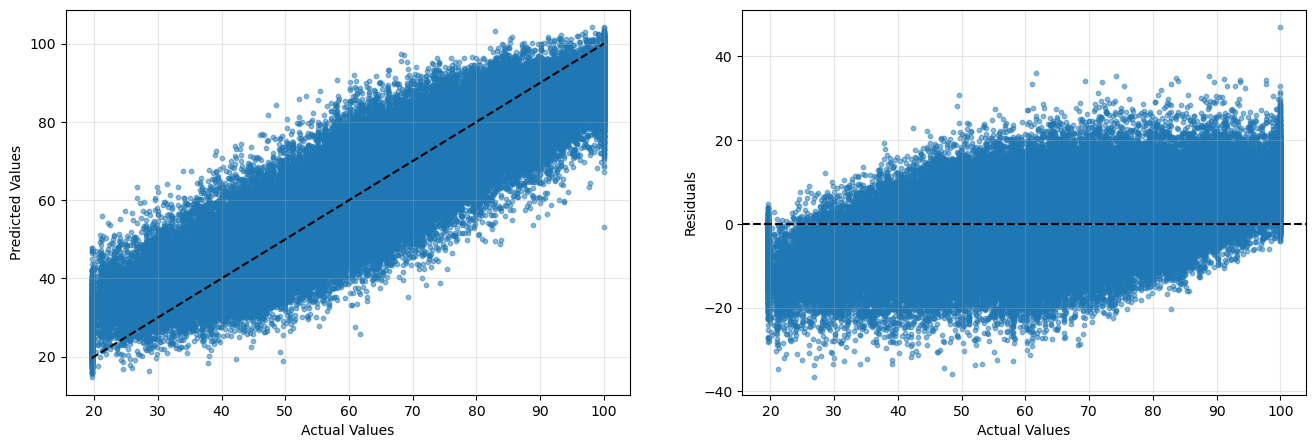

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

y_pred = score["y_pred"]

# 1. Actual vs Predicted
axes[0].scatter(y_valid, y_pred, alpha=0.5, s=10)
axes[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color="black", linestyle="--")
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_valid - y_pred
axes[1].scatter(y_valid, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color="black", linestyle="--")
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

There is a lot of spread around the dashed line representing a "perfect" match with the ground truth. Also something is happening at the boundaries...

First model to try and it doesn't seem to be a good fit! :-/

## Inference

We can finally make predictions on the test set and use them to submit a file to the competition:

In [43]:
# load test CSV file
test_df = pd.read_csv(test_filename)
test_df.head(n=2)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy


Make predictions on test set, the pipeline takes care of encode and scale values in each of the corresponding columns:

In [44]:
preds = pipeline.predict(test_df)

### Submission


Create DataFrame and submit file to competition:

In [45]:
sub_df = pd.DataFrame({"id": test_df.id, "exam_score": preds})
sub_df.to_csv("submission.csv", index=False)
sub_df.head(n=2)

,id,exam_score
0,630000,70.008461
1,630001,70.385895
